In [0]:
import time
import pandas as pd
import numpy as np
import datetime
import itertools
from google.colab import drive
from collections import defaultdict
from scipy.special import softmax
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from google.colab import files

In [2]:
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
######### load and process data #########
data = pd.read_csv('/content/gdrive/Shared drives/CS 238/time_series_60min_singleindex.csv')
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

filter_col = ['utc_timestamp'] + [col for col in data if col.startswith('DE')]
data = data[filter_col]

data = data[data['utc_timestamp'] >= datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)]
data = data[data['utc_timestamp'] < datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)]
data = data.reset_index().drop(columns=['index'])

columns = ['utc_timestamp', 'DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual', 'DE_wind_generation_actual']
data = data[columns]

data.rename(columns={'utc_timestamp': 'timestamp', 'DE_load_actual_entsoe_transparency': 'load', 'DE_solar_generation_actual': 'solar', 'DE_wind_generation_actual': 'wind'}, inplace=True)

n_buckets = {
    'time_of_day': 12,
    'time_of_year': 4,
    'load_scaled': 10,
    'solar_scaled': 5,
    'wind_scaled': 9,
}

def scale(col, n_buckets):
  return (col - col.min()) / (col.max() - col.min()) * (n_buckets - 1)

data['time_of_day'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().hour), n_buckets['time_of_day'])
data['time_of_year'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().month - 1 + (timestamp.to_pydatetime().day - 1) / 31.0), n_buckets['time_of_year'])
data['load_scaled'] = scale(data['load'], n_buckets['load_scaled'])
data['solar_scaled'] = scale(data['solar'], n_buckets['solar_scaled'])
data['wind_scaled'] = scale(data['wind'], n_buckets['wind_scaled'])

train_ = data[data['timestamp'] < datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)] 
test = data[data['timestamp'] >= datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)].reset_index().drop(columns=['index'])

In [0]:
######### define functions #########
def get_neighbor_weights(data_state):
  data_state = np.array(data_state)
  neighbors = list(itertools.product(*((np.floor(s), np.ceil(s)) for s in data_state)))
  weights = []
  for neighbor in neighbors:
    neighbor = np.array(neighbor)
    weights.append(np.linalg.norm(1 - np.abs(data_state - neighbor)))

  weights = np.array(weights)
  return neighbors, weights / weights.sum()


#gives you the valid actions from a given plant state
def get_valid_actions(plant_state):
  num_on = plant_state[0]
  num_off = n-sum(plant_state)
  return np.arange(-plant_state[0], num_off+1)


def get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights):
  Q_a = np.zeros(len(valid_actions))
  for i, action in enumerate(valid_actions):
    for j, neighbor_state in enumerate(neighbor_states):
      Q_a[i] += neighbor_weights[j] * Q[(neighbor_state + plant_state, action)]

  return Q_a


def update_plant_state(plant_state, action):
  if action >= 0:
    return (plant_state[0] + plant_state[1],) + plant_state[2:] + (action,)
  else:
    return (plant_state[0] + plant_state[1] + action,) + plant_state[2:] + (0,)

def get_data_state(row):
  return (row['time_of_day'], row['time_of_year'], row['load_scaled'], row['solar_scaled'], row['wind_scaled'])

In [5]:
######### evaluate random policy #########
n = 16
n_random_runs = 5
reward_sum_random = 0.0

for _ in range(n_random_runs):
  plant_state = (0,0,0)

  for ind, row in test[:-1].iterrows():
    valid_actions = get_valid_actions(plant_state)
    action = np.random.choice(valid_actions)

    plant_state = update_plant_state(plant_state, action)
    next_row = test.loc[ind+1]
    diff = plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']

    reward = -5000.0 * plant_state[0]
    if diff < 0:
      reward += 10*diff
    reward_sum_random += reward

reward_sum_random /= n_random_runs
print('random policy reward sum: {:.1f}'.format(reward_sum_random))

random policy reward sum: -1671177786.0


In [7]:
######### load Q #########
Y = [] # for plotting, will have the performance as compared to the random policy
epoch = 510
Q = pickle.load(open('/content/gdrive/Shared drives/CS 238/Q_2_hour_fixed.{}'.format(epoch), 'rb'))
Q = defaultdict(lambda: -725000.0, Q)

  ######### extract and evaluate optimal policy #########
optimal_policy = []
production = [0]
reward_sum_optimal = 0.0
plant_state = (0,0,0)
  

for ind, row in test[:-1].iterrows():
  data_state = get_data_state(row)
  neighbor_states, neighbor_weights = get_neighbor_weights(data_state)
  valid_actions = get_valid_actions(plant_state)
  Q_a = get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights)

  action = valid_actions[np.argmax(Q_a)]
  optimal_policy.append(action)

  plant_state = update_plant_state(plant_state, action)
  next_row = test.loc[ind+1]
  diff = plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']
  production.append(5000.0*plant_state[0])

  reward = -5000.0 * plant_state[0]
  if diff < 0:
    reward += 10*diff
  reward_sum_optimal += reward

print('##################### {:02d} epochs of training #####################'.format(epoch))
print('optimal policy reward sum: {:.1f}'.format(reward_sum_optimal))
print('random  policy has {:.1f}% more negative reward than optimal policy'.format((reward_sum_random / reward_sum_optimal - 1) * 100))
Y.append(((reward_sum_random / reward_sum_optimal - 1) * 100))
print()

##################### 510 epochs of training #####################
optimal policy reward sum: -569259360.0
random  policy has 193.6% more negative reward than optimal policy



In [8]:
production[0] = 0.0
optimal_policy.append(0)

test["production"] = production
test["optimal action"] = optimal_policy
test.loc[0]

timestamp         2018-01-01 00:00:00+00:00
load                                  43342
solar                                     0
wind                                  33105
time_of_day                               0
time_of_year                              0
load_scaled                         2.24716
solar_scaled                              0
wind_scaled                         5.92799
production                                0
optimal action                            1
Name: 0, dtype: object

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


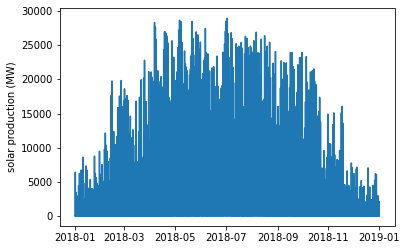

In [9]:
X = test["timestamp"]
Y = test["solar"]
plt.ylabel("solar production (MW)")
plt.plot(X,Y)

In [10]:
daytime = test[test["timestamp"].dt.hour >7]
daytime = daytime[daytime["timestamp"].dt.hour < 17]
daytime = daytime.reset_index().drop(columns=['index'])
print(daytime[:10])

                  timestamp     load  ...  production  optimal action
0 2018-01-01 08:00:00+00:00  44525.0  ...         0.0               0
1 2018-01-01 09:00:00+00:00  46875.0  ...         0.0               0
2 2018-01-01 10:00:00+00:00  49419.0  ...         0.0               0
3 2018-01-01 11:00:00+00:00  51191.0  ...         0.0               0
4 2018-01-01 12:00:00+00:00  50351.0  ...         0.0               0
5 2018-01-01 13:00:00+00:00  49115.0  ...         0.0               0
6 2018-01-01 14:00:00+00:00  48649.0  ...         0.0               0
7 2018-01-01 15:00:00+00:00  50695.0  ...         0.0               0
8 2018-01-01 16:00:00+00:00  54018.0  ...         0.0               8
9 2018-01-02 08:00:00+00:00  64201.0  ...     30000.0               0

[10 rows x 11 columns]


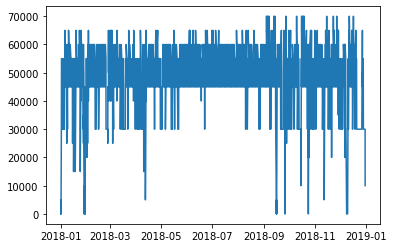

In [24]:
nightime = test[test["timestamp"].dt.hour <= 7]
nightime.append(test[test["timestamp"].dt.hour >= 17])
plt.plot(nightime["timestamp"],nightime["production"])


In [0]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
coal_production = []
load = []
solar = []
wind = []

for i in range(0,12):
  month = months[i]
  coal_production.append(np.mean(test[test["timestamp"].dt.month == i+1]["production"]))
  load.append(np.mean(test[test["timestamp"].dt.month == i+1]["load"]))
  solar.append(np.mean(test[test["timestamp"].dt.month == i+1]["solar"]))
  wind.append(np.mean(test[test["timestamp"].dt.month == i+1]["wind"]))

data = {'month' : months, 'coal_production(MW)' : coal_production, 'load (MW)' : load, 'solar (MW)' : solar, 'wind (MW)' : wind}
interpretation_df=pd.DataFrame(data)

In [13]:
print(interpretation_df)

    month  coal_production(MW)     load (MW)   solar (MW)     wind (MW)
0     Jan         46229.838710  61272.025538   981.391129  19415.655914
1     Feb         50319.940476  61609.861607  2724.761905  11838.733631
2   March         48817.204301  60704.291667  3634.767473  14324.864247
3   April         47979.166667  55618.655556  6715.780556  12409.548611
4     May         49395.161290  55542.122312  7972.439516   9635.377688
5    June         52083.333333  56848.423611  7412.141667   8005.388889
6    July         52755.376344  55756.709677  8288.877688   5934.654570
7     Aug         50557.795699  56353.233871  6967.032258   8230.353495
8    Sept         47875.000000  56882.852778  5651.858333  11086.133333
9     Oct         47197.580645  57951.372312  3694.340054  14439.634409
10    Nov         50305.555556  60661.191667  1626.340278  13809.520833
11    Dec         40806.451613  57798.737903   706.442204  19401.059140


In [14]:
from tabulate import tabulate
print(tabulate(interpretation_df, headers='keys', tablefmt='psql'))

+----+---------+-----------------------+-------------+--------------+-------------+
|    | month   |   coal_production(MW) |   load (MW) |   solar (MW) |   wind (MW) |
|----+---------+-----------------------+-------------+--------------+-------------|
|  0 | Jan     |               46229.8 |     61272   |      981.391 |    19415.7  |
|  1 | Feb     |               50319.9 |     61609.9 |     2724.76  |    11838.7  |
|  2 | March   |               48817.2 |     60704.3 |     3634.77  |    14324.9  |
|  3 | April   |               47979.2 |     55618.7 |     6715.78  |    12409.5  |
|  4 | May     |               49395.2 |     55542.1 |     7972.44  |     9635.38 |
|  5 | June    |               52083.3 |     56848.4 |     7412.14  |     8005.39 |
|  6 | July    |               52755.4 |     55756.7 |     8288.88  |     5934.65 |
|  7 | Aug     |               50557.8 |     56353.2 |     6967.03  |     8230.35 |
|  8 | Sept    |               47875   |     56882.9 |     5651.86  |    110

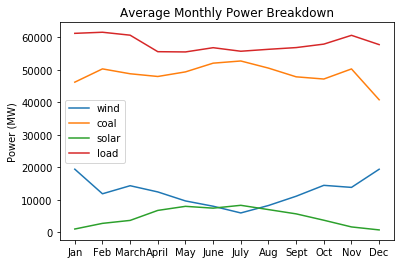

In [15]:
plt.plot(interpretation_df["month"],interpretation_df["wind (MW)"], label = 'wind')
plt.plot(interpretation_df["month"],interpretation_df["coal_production(MW)"], label = 'coal')
plt.plot(interpretation_df["month"],interpretation_df["solar (MW)"], label = 'solar')
plt.plot(interpretation_df["month"],interpretation_df["load (MW)"], label = 'load')
plt.legend(loc='center left')
plt.title("Average Monthly Power Breakdown")
plt.ylabel("Power (MW)")
plt.savefig('average.png')

files.download('average.png')

#yo this is super fucking whack

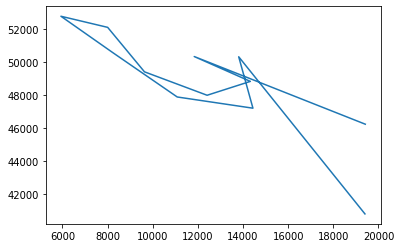

In [17]:
plt.plot(interpretation_df["wind (MW)"], interpretation_df["coal_production(MW)"])

In [25]:
average_night = np.mean(nightime["production"])
average_day = np.mean(daytime["production"])
print(average_day)
print(average_day)
print(len(daytime))
print(len(nightime))


49124.8097412481
49124.8097412481
3285
2920
